In [1]:
from keras import layers
import numpy as np
import pandas as pd
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,Activation,BatchNormalization,Input,Dense,Add,Flatten
from keras.layers import GlobalMaxPooling2D,ZeroPadding2D
from keras.models import Model
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [2]:


def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X =Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    
    return X

In [3]:


def convolutional_block(X, f, filters, stage, block, s = 2):
    
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   

    # Second component of main path (≈3 lines)
    X = Conv2D(F2,(f,f),strides=(1,1),name=conv_name_base +'2b',padding='same',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3,(1,1),strides=(1,1),name=conv_name_base +'2c',padding='valid',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base +'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3,(1,1),strides=(s,s),name=conv_name_base +'1',padding='valid',kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base +'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    
    return X

In [4]:


def ResNet50(input_shape = (64, 64, 3), classes = 6):
   
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

   

    # Stage 3 (≈4 lines)
    X = convolutional_block(X,f=3,filters=[128,128,512],stage=3,block='a',s=2)
    X = identity_block(X,3,[128,128,512],stage=3,block='b')
    X = identity_block(X,3,[128,128,512],stage=3,block='c')
    X = identity_block(X,3,[128,128,512],stage=3,block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X,f=3,filters=[256,256,1024],stage=4,block='a',s=2)
    X = identity_block(X,3,[256,256,1024],stage=4,block='b')
    X = identity_block(X,3,[256,256,1024],stage=4,block='c')
    X = identity_block(X,3,[256,256,1024],stage=4,block='d')
    X = identity_block(X,3,[256,256,1024],stage=4,block='e')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2,2))(X)
    
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes = 1)

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model.load_weights("Weight_Mustache.h5")

In [10]:
import cv2 as cv
import matplotlib.pyplot as plt

In [11]:
def predict(img):
    plt.imshow(img)
    plt.show()
    img=cv.resize(img,(64,64))
    img=img.reshape(1,64,64,3)/255
    return model.predict(img)
    
    

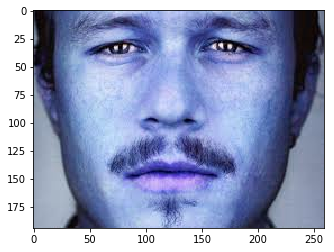

array([[ 0.00062718]], dtype=float32)

In [12]:
test_image=cv.imread("Images/lf7.jpeg")

predict(test_image)